In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


In [2]:
df = pd.read_csv('smoking_driking_dataset_Ver01.csv')

In [3]:
df['DRK_YN'] = df['DRK_YN'].map({'Y': 1, 'N': 0})

C:\Users\ketoan\AppData\Local\Temp\ipykernel_18776\1988319266.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


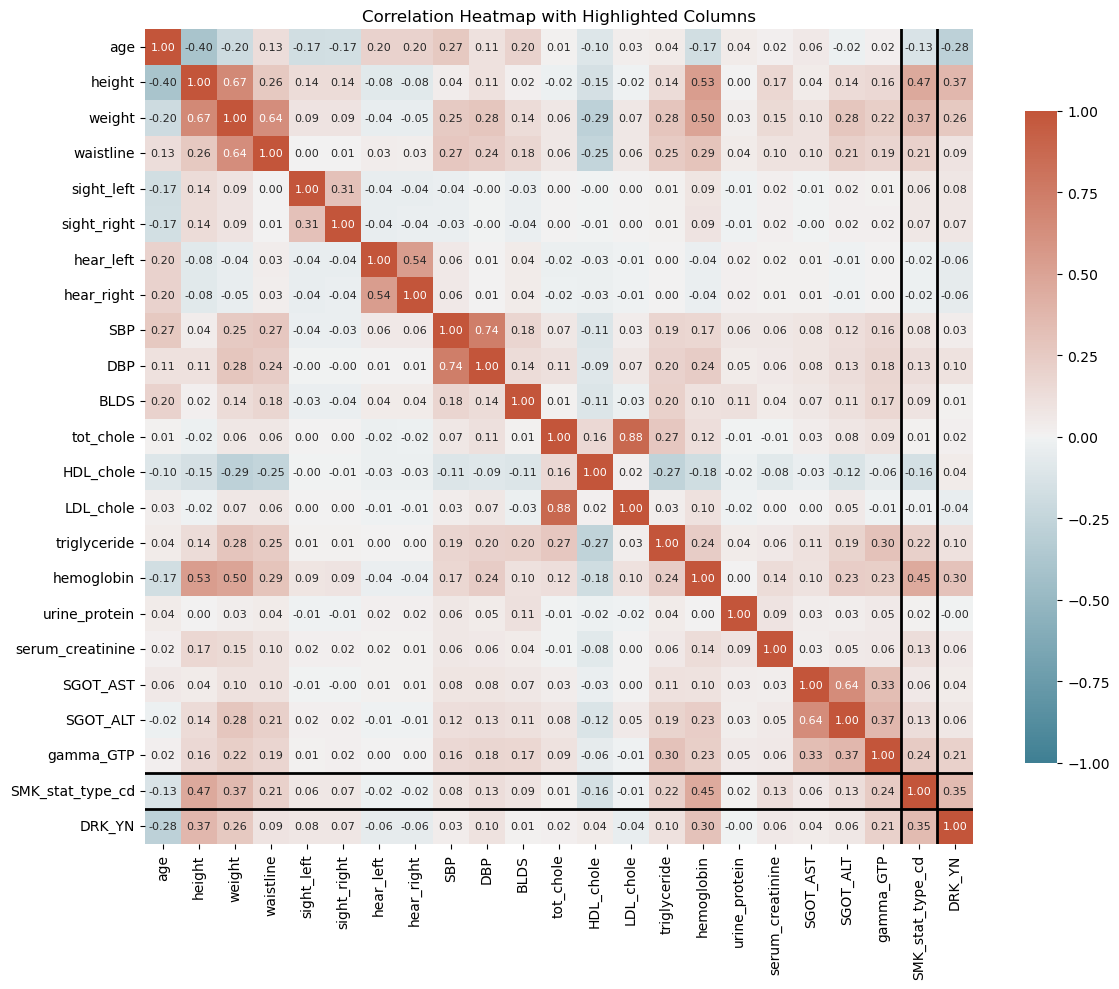

In [4]:
correlation_matrix = df.corr()

# Specify columns to highlight
highlight_cols = ['DRK_YN', 'SMK_stat_type_cd']

# Create a larger heatmap with adjusted font size
plt.figure(figsize=(12, 10))

# Define custom color palette for the heatmap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Plot the heatmap with custom colors for highlighted columns
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, center=0, fmt=".2f", annot_kws={"size": 8},
            cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1)

# Highlight columns by drawing lines around them
for i in range(len(correlation_matrix.columns)):
    if correlation_matrix.columns[i] in highlight_cols:
        plt.axhline(i, color='k', linewidth=2)
        plt.axvline(i, color='k', linewidth=2)

plt.title('Correlation Heatmap with Highlighted Columns')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [5]:
correlation_threshold = 0.1
DRK_features = []
for feature in correlation_matrix.columns:
    if feature != 'DRK_YN' and (correlation_matrix[feature]['DRK_YN'] > correlation_threshold or
                                correlation_matrix[feature]['DRK_YN'] < -correlation_threshold):
        DRK_features.append(feature)

print("Correlated features with 'DRK_YN':")
print(DRK_features)

Correlated features with 'DRK_YN':
['age', 'height', 'weight', 'DBP', 'triglyceride', 'hemoglobin', 'gamma_GTP', 'SMK_stat_type_cd']


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,991346.0,47.614491,14.181339,20.0,35.0,45.0,60.0,85.0
height,991346.0,162.240625,9.282957,130.0,155.0,160.0,170.0,190.0
weight,991346.0,63.284050,12.514241,25.0,55.0,60.0,70.0,140.0
waistline,991346.0,81.233358,11.850323,8.0,74.1,81.0,87.8,999.0
sight_left,991346.0,0.980834,0.605949,0.1,0.7,1.0,1.2,9.9
sight_right,991346.0,0.978429,0.604774,0.1,0.7,1.0,1.2,9.9
hear_left,991346.0,1.031495,0.174650,1.0,1.0,1.0,1.0,2.0
hear_right,991346.0,1.030476,0.171892,1.0,1.0,1.0,1.0,2.0
SBP,991346.0,122.432498,14.543148,67.0,112.0,120.0,131.0,273.0
DBP,991346.0,76.052627,9.889365,32.0,70.0,76.0,82.0,185.0


In [7]:
import pandas as pd

def remove_outliers_iqr(df, column):
    """
    Loại bỏ outliers từ một cột của DataFrame sử dụng phương pháp IQR.

    Parameters:
    - df: DataFrame
    - column: str, tên cột cần loại bỏ outliers

    Returns:
    - DataFrame mới sau khi loại bỏ outliers
    """
    # Lấy dữ liệu từ cột cần xử lý
    data = df[column]

    # Tính phân vị 25% và 75%
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)

    # Tính khoảng tứ phân vị (IQR)
    IQR = Q3 - Q1

    # Xác định ranh giới trên và dưới để xác định outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Lọc các giá trị nằm ngoài ranh giới
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return filtered_df

# Đọc dữ liệu từ CSV file
df = pd.read_csv("smoking_driking_dataset_Ver01.csv", encoding="ISO-8859-1")

# Chọn cột cần loại bỏ outliers (ví dụ: "your_column_name")
column_name = "your_column_name"


In [8]:
df = remove_outliers_iqr(df, 'age')
df = remove_outliers_iqr(df, 'height')
df = remove_outliers_iqr(df, 'weight')
df = remove_outliers_iqr(df, 'waistline')
df = remove_outliers_iqr(df, 'sight_left')
df = remove_outliers_iqr(df, 'sight_right')
df = remove_outliers_iqr(df, 'hear_right')
df = remove_outliers_iqr(df, 'hear_left')
df = remove_outliers_iqr(df, 'SBP')
df = remove_outliers_iqr(df, 'DBP')
df = remove_outliers_iqr(df, 'BLDS')
df = remove_outliers_iqr(df, 'tot_chole')
df = remove_outliers_iqr(df, 'HDL_chole')
df = remove_outliers_iqr(df, 'LDL_chole')
df = remove_outliers_iqr(df, 'triglyceride')
df = remove_outliers_iqr(df, 'hemoglobin')
df = remove_outliers_iqr(df, 'urine_protein')
df = remove_outliers_iqr(df, 'serum_creatinine')
df = remove_outliers_iqr(df, 'SGOT_AST')
df = remove_outliers_iqr(df, 'SGOT_ALT')
df = remove_outliers_iqr(df, 'gamma_GTP')

In [9]:
df['age'] = pd.cut (df['age'], bins = [20,35,45,60,85])

df['height'] = pd.cut (df['height'], bins = [130,155,160,170,190])

df['weight'] = pd.cut (df['weight'], bins = [35,50,60,65,90])

df['waistline'] = pd.cut (df['waistline'], bins = [55.3,72.0,78.0,84.0,104.0])

df['sight_left'] = pd.cut (df['sight_left'], bins = [0.3,0.8,1.0,1.2,1.7])

df['sight_right'] = pd.cut (df['sight_right'], bins = [0.3,0.8,1.0,1.2,1.7])

df['hear_left'] = pd.cut (df['hear_left'], bins = [0,1,2])

df['hear_right'] = pd.cut (df['hear_right'], bins = [0,1,2])

df['SBP'] = pd.cut (df['SBP'], bins = [83.0,110.0,119.0,128.0,157.0])

df['DBP'] = pd.cut (df['DBP'], bins = [55.0,68.0,74.0,80.0,95.0])

df['BLDS'] = pd.cut (df['BLDS'], bins = [68.0,87.0,93.0,100.0,119.0])

df['tot_chole'] = pd.cut (df['tot_chole'], bins = [102.0,168.0,190.0,213.0,281.0])

df['HDL_chole'] = pd.cut (df['HDL_chole'], bins = [20.0,49.0,58.0,68.0,94.0])

df['LDL_chole'] = pd.cut (df['LDL_chole'], bins = [28.0,91.0,111.0,133.0,196.0])

df['triglyceride'] = pd.cut (df['triglyceride'], bins = [1.0,65.0,90.0,124.0,227.0])

df['hemoglobin'] = pd.cut (df['hemoglobin'], bins = [9.9,13.0,13.9,15.0,18.2])

df['serum_creatinine'] = pd.cut (df['serum_creatinine'], bins = [0.3,0.7,0.8,0.9,1.4])

df['SGOT_AST'] = pd.cut (df['SGOT_AST'], bins = [8.0,18.0,21.0,24.0,35.0])

df['SGOT_ALT'] = pd.cut (df['SGOT_ALT'], bins = [1.0,13.0,17.0,22.0,38.0])

df['gamma_GTP'] = pd.cut (df['gamma_GTP'], bins = [1.0,14.0,18.0,25.0,44.0])

In [10]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
df["sex"] = lb_make.fit_transform(df["sex"])
df["DRK_YN"] = lb_make.fit_transform(df["DRK_YN"])
df["height"] = lb_make.fit_transform(df["height"])
df["weight"] = lb_make.fit_transform(df["weight"])
df["waistline"] = lb_make.fit_transform(df["waistline"])
df["sight_left"] = lb_make.fit_transform(df["sight_left"])
df["sight_right"] = lb_make.fit_transform(df["sight_right"])
df["LDL_chole"] = lb_make.fit_transform(df["LDL_chole"])
df["HDL_chole"] = lb_make.fit_transform(df["HDL_chole"])
df["tot_chole"] = lb_make.fit_transform(df["tot_chole"])
df["BLDS"] = lb_make.fit_transform(df["BLDS"])
df["DBP"] = lb_make.fit_transform(df["DBP"])
df["SBP"] = lb_make.fit_transform(df["SBP"])
df["hear_right"] = lb_make.fit_transform(df["hear_right"])
df["hear_left"] = lb_make.fit_transform(df["hear_left"])
df["age"] = lb_make.fit_transform(df["age"])
df["gamma_GTP"] = lb_make.fit_transform(df["gamma_GTP"])
df["SGOT_ALT"] = lb_make.fit_transform(df["SGOT_ALT"])
df["SGOT_AST"] = lb_make.fit_transform(df["SGOT_AST"])
df["serum_creatinine"] = lb_make.fit_transform(df["serum_creatinine"])
df["hemoglobin"] = lb_make.fit_transform(df["hemoglobin"])
df["triglyceride"] = lb_make.fit_transform(df["triglyceride"])
df["SMK_stat_type_cd"] = lb_make.fit_transform(df["SMK_stat_type_cd"])
df["DRK_YN"] = lb_make.fit_transform(df["DRK_YN"])

In [11]:
features = ['age', 'height', 'weight', 'DBP', 'triglyceride', 'hemoglobin', 'gamma_GTP']
target = ['DRK_YN']
X = df[features]
y = df[target]
print(X)
print(y)

        age  height  weight  DBP  triglyceride  hemoglobin  gamma_GTP
0         0       2       3    2             2           3          3
1         0       3       3    3             2           3          3
3         2       3       3    3             2           3          1
4         2       2       1    3             2           1          2
6         1       0       1    0             1           0          0
...     ...     ...     ...  ...           ...         ...        ...
991339    3       2       1    2             2           3          3
991340    2       0       0    1             3           3          3
991341    1       3       3    2             3           2          3
991342    0       2       3    3             0           3          1
991344    0       3       1    1             0           2          1

[577958 rows x 7 columns]
        DRK_YN
0            1
1            0
3            0
4            0
6            0
...        ...
991339       1
991340       

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train)
print(y_train)
print(X_test)
print(y_test)

        age  height  weight  DBP  triglyceride  hemoglobin  gamma_GTP
930831    1       1       1    1             0           1          1
272123    2       0       1    2             3           1          2
938174    2       1       1    1             1           1          0
115815    3       1       2    3             3           3          3
683513    0       1       1    2             1           0          0
...     ...     ...     ...  ...           ...         ...        ...
606655    4       0       0    2             0           0          0
937190    0       2       3    2             3           2          3
265694    0       1       0    0             1           2          1
484222    2       1       3    1             2           2          1
414995    3       0       1    3             1           1          2

[462366 rows x 7 columns]
        DRK_YN
930831       1
272123       0
938174       0
115815       1
683513       0
...        ...
606655       1
937190       

In [13]:
from sklearn import tree
model=tree.DecisionTreeClassifier(criterion = "entropy",
random_state = 100,
max_depth = 4,
min_samples_leaf = 10)

In [14]:
model = model.fit(X_train,y_train)

[Text(0.5, 0.9, 'x[1] <= 1.5\nentropy = 0.995\nsamples = 462366\nvalue = [249790, 212576]'),
 Text(0.25, 0.7, 'x[0] <= 1.5\nentropy = 0.909\nsamples = 258938\nvalue = [175028, 83910]'),
 Text(0.125, 0.5, 'x[6] <= 1.5\nentropy = 0.993\nsamples = 104540\nvalue = [57414, 47126]'),
 Text(0.0625, 0.3, 'x[0] <= 0.5\nentropy = 0.975\nsamples = 72272\nvalue = [42783, 29489]'),
 Text(0.03125, 0.1, 'entropy = 0.999\nsamples = 31466\nvalue = [16154, 15312]'),
 Text(0.09375, 0.1, 'entropy = 0.932\nsamples = 40806\nvalue = [26629, 14177]'),
 Text(0.1875, 0.3, 'x[0] <= 0.5\nentropy = 0.994\nsamples = 32268\nvalue = [14631, 17637]'),
 Text(0.15625, 0.1, 'entropy = 0.956\nsamples = 11224\nvalue = [4238, 6986]'),
 Text(0.21875, 0.1, 'entropy = 1.0\nsamples = 21044\nvalue = [10393, 10651]'),
 Text(0.375, 0.5, 'x[1] <= 0.5\nentropy = 0.792\nsamples = 154398\nvalue = [117614, 36784]'),
 Text(0.3125, 0.3, 'x[0] <= 3.5\nentropy = 0.699\nsamples = 110866\nvalue = [89936, 20930]'),
 Text(0.28125, 0.1, 'entrop

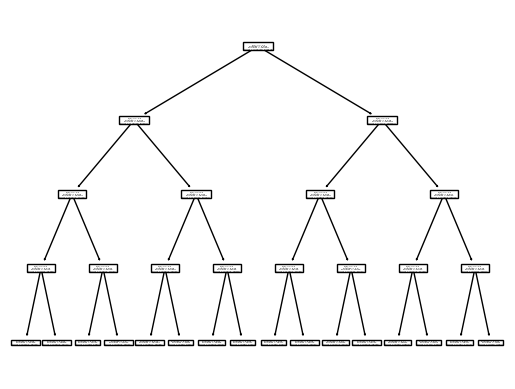

In [15]:
tree.plot_tree(model)

In [16]:

print(tree.export_text(model,show_weights = True))

|--- feature_1 <= 1.50
|   |--- feature_0 <= 1.50
|   |   |--- feature_6 <= 1.50
|   |   |   |--- feature_0 <= 0.50
|   |   |   |   |--- weights: [16154.00, 15312.00] class: 0
|   |   |   |--- feature_0 >  0.50
|   |   |   |   |--- weights: [26629.00, 14177.00] class: 0
|   |   |--- feature_6 >  1.50
|   |   |   |--- feature_0 <= 0.50
|   |   |   |   |--- weights: [4238.00, 6986.00] class: 1
|   |   |   |--- feature_0 >  0.50
|   |   |   |   |--- weights: [10393.00, 10651.00] class: 1
|   |--- feature_0 >  1.50
|   |   |--- feature_1 <= 0.50
|   |   |   |--- feature_0 <= 3.50
|   |   |   |   |--- weights: [88597.00, 19085.00] class: 0
|   |   |   |--- feature_0 >  3.50
|   |   |   |   |--- weights: [1339.00, 1845.00] class: 1
|   |   |--- feature_1 >  0.50
|   |   |   |--- feature_6 <= 2.50
|   |   |   |   |--- weights: [21296.00, 9109.00] class: 0
|   |   |   |--- feature_6 >  2.50
|   |   |   |   |--- weights: [6382.00, 6745.00] class: 1
|--- feature_1 >  1.50
|   |--- feature_6 <= 2

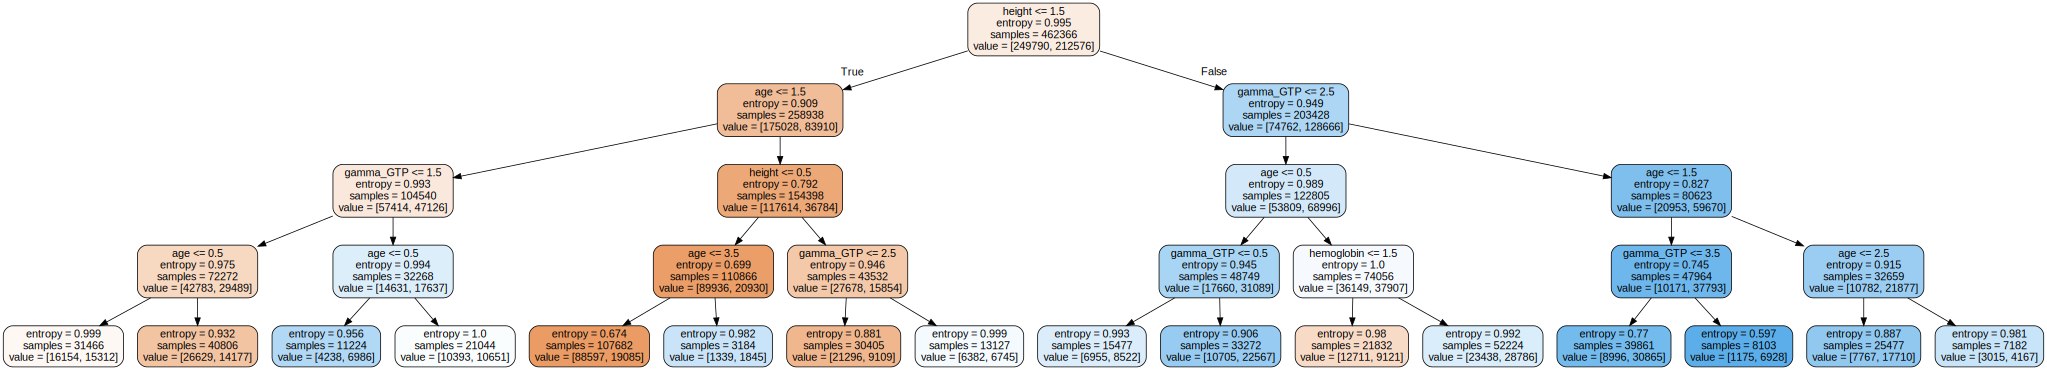

In [17]:
import graphviz
dot_data = tree.export_graphviz(model, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("df")
dot_data = tree.export_graphviz(model,out_file = None,
feature_names=features,
filled =True,
rounded = True )
graph = graphviz.Source(dot_data)
graph

In [18]:
y_pred = model.predict(X_test)
print("Giá trị nhãn mô hình dự đoán được:\n " ,y_pred)

Giá trị nhãn mô hình dự đoán được:
  [0 1 0 ... 1 1 0]


Confusion Matrix: 
 [[41254 21310]
 [16744 36284]]


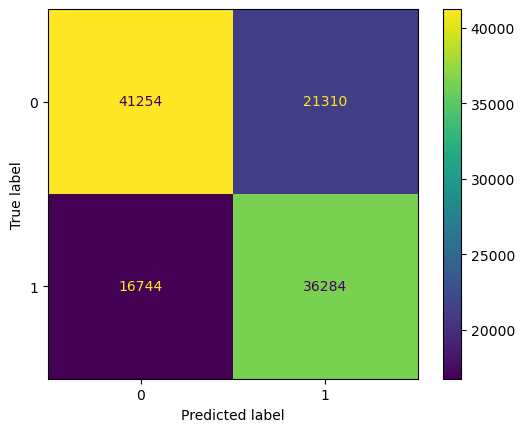

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print(ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred)).plot())

In [20]:
print ("Accuracy : ", accuracy_score(y_test,y_pred)*100)

Accuracy :  67.07903661153021


In [21]:
from sklearn.metrics import classification_report

#Ma trận độ chính xác mô hình
print (classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.66      0.68     62564
           1       0.63      0.68      0.66     53028

    accuracy                           0.67    115592
   macro avg       0.67      0.67      0.67    115592
weighted avg       0.67      0.67      0.67    115592



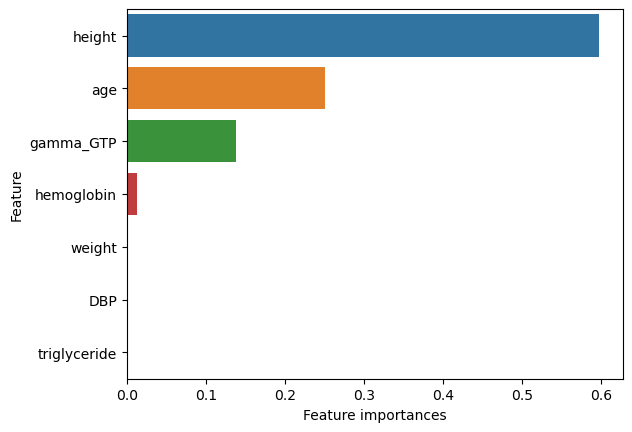

In [22]:
import seaborn as sns

import matplotlib.pyplot as plt
importances = model.feature_importances_
features_importances = pd.Series(importances, index = X.columns).sort_values(ascending = False)
sns.barplot (x = features_importances, y = features_importances.index)
plt.xlabel ('Feature importances')
plt.ylabel ('Feature')
plt.show()

In [23]:
new_ps=pd.DataFrame({'age': [20], 'height': [180],'weight':[75],'DBP':[91],'triglyceride':[232],'hemoglobin':[13.1],'gamma_GTP':[26]})

In [24]:
drk_pred = model.predict(new_ps)
print(drk_pred)

[1]


In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# Predict the target variable on the test set
y_pred = model.predict(X_test_scaled)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

d:\anaconda\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.6755052252751056


In [ ]:
from sklearn.metrics import classification_report

#Ma trận độ chính xác mô hình
print (classification_report(y_test,y_pred))